In [0]:
# Importing all the necessary required modules and libraries.


from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Defining the network by initializing the layers and then building the model using the forward function.
# We have taken taken simple 3x3 convolution followed by BatchNormalization and dropout
# Maxpooling was done to reduce the number of parameters

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
                
        self.conv1 = nn.Conv2d(1,16,3) #out put 26*26*16
        self.batchn1 = nn.BatchNorm2d(16)
        self.drop1 = nn.Dropout(p=0.1);

        self.conv2 = nn.Conv2d(16,16,3) # 24*24*16
        self.batchn2 = nn.BatchNorm2d(16)
        self.drop2 = nn.Dropout(p=0.15);

        self.conv3 = nn.Conv2d(16,16,3) # output 22*22*16
        self.batchn3 = nn.BatchNorm2d(16)
        self.drop3 = nn.Dropout(p=0.15)

        self.pool1 = nn.MaxPool2d(2,2) #output 11*11*16
        
        self.onecross = nn.Conv2d(16,16,1) #output 11*11*16
        
        self.conv4 = nn.Conv2d(16,16,3) #output 9*9*16
        self.batchn4 = nn.BatchNorm2d(16)
        self.drop4 = nn.Dropout(p=0.15);

        self.conv5 = nn.Conv2d(16,16,3) #output 7*7*16
        self.batchn5 = nn.BatchNorm2d(16)
        self.drop5 = nn.Dropout(p=0.15);

        self.conv6 = nn.Conv2d(16,10,7) #output 1*1*10

    def forward(self, x):
        x = self.drop2(self.batchn2(F.relu(self.conv2(self.drop1(self.batchn1(F.relu(self.conv1(x))))))))
        x = self.drop4(self.batchn4(F.relu(self.conv4(self.onecross(self.pool1(self.drop3(self.batchn3(F.relu(self.conv3(x))))))))))
        x = self.conv6(self.drop5(self.batchn5(F.relu(self.conv5(x)))))
        #x = self.conv6(self.conv5(x))
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [24]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# model = Net().to(device)
# summary(model, input_size=(1, 28, 28))

In [25]:
# Model summary device here.
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
           Dropout-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           2,320
       BatchNorm2d-5           [-1, 16, 24, 24]              32
           Dropout-6           [-1, 16, 24, 24]               0
            Conv2d-7           [-1, 16, 22, 22]           2,320
       BatchNorm2d-8           [-1, 16, 22, 22]              32
           Dropout-9           [-1, 16, 22, 22]               0
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11           [-1, 16, 11, 11]             272
           Conv2d-12             [-1, 16, 9, 9]           2,320
      BatchNorm2d-13             [-1, 16, 9, 9]              32
          Dropout-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


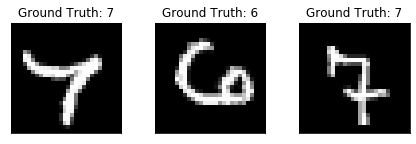

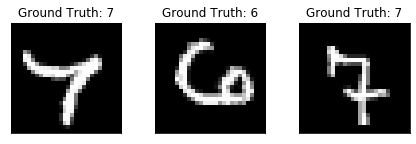

In [27]:
import matplotlib.pyplot as plt
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [0]:
from tqdm import tqdm
test_accuracies = []
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
        

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_accuracies.append(100. * correct / len(test_loader.dataset))

In [29]:
# Training and testing the model and viewing accuracy.
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print ('\n--------EPOCH {}-----------'.format(epoch))
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]


--------EPOCH 1-----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9843/10000 (98.43%)


--------EPOCH 2-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9872/10000 (98.72%)


--------EPOCH 3-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9886/10000 (98.86%)


--------EPOCH 4-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9895/10000 (98.95%)


--------EPOCH 5-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9910/10000 (99.10%)


--------EPOCH 6-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9909/10000 (99.09%)


--------EPOCH 7-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9923/10000 (99.23%)


--------EPOCH 8-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9913/10000 (99.13%)


--------EPOCH 9-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9922/10000 (99.22%)


--------EPOCH 10-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9921/10000 (99.21%)


--------EPOCH 11-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9919/10000 (99.19%)


--------EPOCH 12-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9930/10000 (99.30%)


--------EPOCH 13-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9924/10000 (99.24%)


--------EPOCH 14-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9925/10000 (99.25%)


--------EPOCH 15-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9906/10000 (99.06%)


--------EPOCH 16-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9934/10000 (99.34%)


--------EPOCH 17-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.40%)


--------EPOCH 18-----------


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9924/10000 (99.24%)


--------EPOCH 19-----------


loss=0.05105030536651611 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.62it/s]



Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.35%)



In [30]:
# Displaying the test accuracy and the threshold to passed.
print(test_accuracies)
threshold = 19*[99.4]
print (threshold)

[98.43, 98.72, 98.86, 98.95, 99.1, 99.09, 99.23, 99.13, 99.22, 99.21, 99.19, 99.3, 99.24, 99.25, 99.06, 99.34, 99.4, 99.24, 99.35]
[99.4, 99.4, 99.4, 99.4, 99.4, 99.4, 99.4, 99.4, 99.4, 99.4, 99.4, 99.4, 99.4, 99.4, 99.4, 99.4, 99.4, 99.4, 99.4]


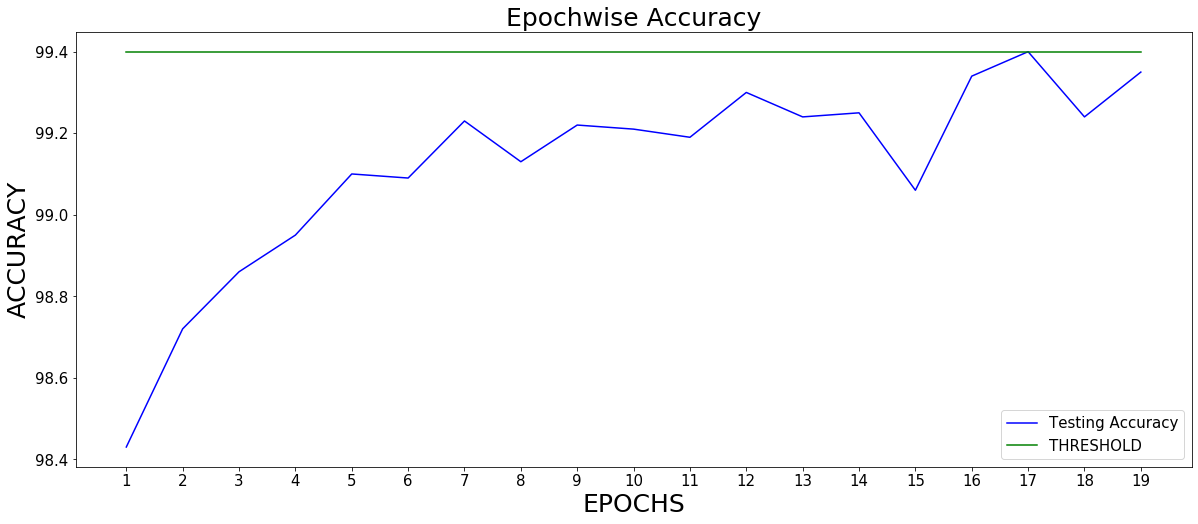

In [31]:
# Below code is to plot the graph between training and testing accuracy 
# From the link below you can see that we have crossed 99.4 threshold.

new_list = range(1,20)

import matplotlib.pyplot as plt
plt.figure(1, figsize=(20, 8))
plt.xticks(range(1,20),fontsize=15)
plt.yticks(fontsize=15)
plt.plot (new_list,test_accuracies,"-b",label="Testing Accuracy")
plt.plot (new_list,threshold,'-g',label='THRESHOLD')
plt.legend(loc="lower right",fontsize=15)
plt.ylabel('ACCURACY',fontsize=25)
plt.xlabel('EPOCHS',fontsize=25)
plt.title('Epochwise Accuracy',fontsize=25)
plt.show()